<a href="https://colab.research.google.com/github/gonzalezzayra/INVESTIGACION-DE-OPERACIONES/blob/main/Inventario_de_varios_art%C3%ADculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modelo "Cantidad económica de pedido de varios artículos con limitación de almacén"**

**Ejercicio 11.2-3**

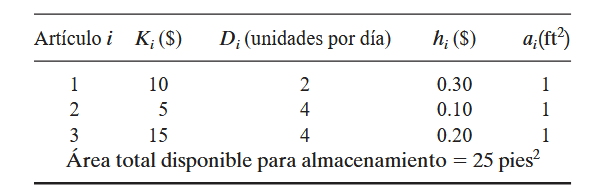

In [39]:
import numpy as np
import sympy as sp
from scipy.optimize import fsolve

numpy es para hacer cálculos con los arreglos.

```
import numpy as np
```

sympy realiza matemáticas simbólicas.

```
import sympy as sp
```

Encuentra numéricamente las raíces de la función

```
from scipy. optimize import fsolve
```

In [40]:
#Datos de la tabla del ejercicio
K = np.array([10, 5, 15])     #Costo de preparacion
D = np.array([2, 4, 4])       #Demanda (unidades/día)
h = np.array([0.3, 0.1, 0.2]) #Costo de inventario
a = np.array([1, 1, 1])       #Area por unidad
Area_Disponible = 25          #Restricción total

In [41]:
#Para definir como simbolos a y, K, D, h, a, y lambda
y_sym, K_sym, D_sym, h_sym, a_sym, lam_sym = sp.symbols('y K D h a lambda')

#Definir el Langrangiano = Costo total - lambda*restriccion
L = (K_sym * D_sym / y_sym) + (h_sym * y_sym / 2) - lam_sym * a_sym * y_sym
dL_dy = sp.diff(L, y_sym)
formula_y = sp.solve(dL_dy, y_sym)[1] #Toma la raiz positiva

print(f"Fórmula general derivada:")
sp.pprint(formula_y)

#Para convertirla en una función normal, ya que antes estaba con sympy
calcular_y = sp.lambdify((K_sym, D_sym, h_sym, a_sym, lam_sym), formula_y, 'numpy')

Fórmula general derivada:
       ___________
      ╱   -D⋅K    
√2⋅  ╱  ───────── 
   ╲╱   2⋅a⋅λ - h 


Calcular la solución no restringida, cuando $λ = 0$

In [42]:
#Calcular y*
y_paso1 = calcular_y(K, D, h, a, 0)
area_paso1 = np.sum(y_paso1 * a)

#Checar los resultados preliminares
print("Resultados preliminares:")
for i, val in enumerate(y_paso1):
    print(f"  Artículo {i+1}: {val:.6f} unidades")

print("Área requerida:", area_paso1)
print("Área disponible: ", Area_Disponible)

Resultados preliminares:
  Artículo 1: 11.547005 unidades
  Artículo 2: 20.000000 unidades
  Artículo 3: 24.494897 unidades
Área requerida: 56.041902811624304
Área disponible:  25


En este caso, la área requerida es mayor al área disponible.

Como mencionamos anteriormente, ya que el área requerida es mayor, necesitamos formar un ciclo para saber que hacer en el caso de que el área requerida si esta dentro de la disponible.

In [43]:
#Checar si se viola la restriccion
viola_restriccion = area_paso1 > Area_Disponible

#Si no se viola
if not viola_restriccion:
    print("El área es suficiente. Es la solución óptima.")
    y_finales = y_paso1
    lambda_final = 0
else:
    print("El área es insuficiente. Se viola la restricción, se necesita hacer otro paso")

    #PASO siguiente cuando el área es insuficiente
    #Encontrar el multiplicador de Lagrange

    #Definimos la función objetivo
    #Se busca que el área usada - disponible sea igual a 0
    def ecuacion_restriccion(lam):
        #El denominador debe ser positivo
        if np.any((h - 2*lam*a) <= 0):
            return 1e6 #Si sale del dominio

        y_vals = calcular_y(K, D, h, a, lam)
        return np.sum(y_vals * a) - Area_Disponible

    #Usamos fsolve buscando un valor negativo (según lo que estaba en el Taha)
    #El valor inicial -0.1 es una buena semilla
    lambda_final = fsolve(ecuacion_restriccion, -0.1)[0]

    print(f"Valor de Lambda encontrado que satisface la restricción:")
    print(f"Lambda* = {lambda_final:.6f}")

    #PASO siguiente, calculatr los valores óptimos
    y_finales = calcular_y(K, D, h, a, lambda_final)
    area_final = np.sum(y_finales * a)

    print(f"{'Artículo':<10} | {'Cantidad (y*)':<15} | {'Área Ocupada':<15}")

    print("-" * 45)
    for i, val in enumerate(y_finales):
        print(f"{i+1:<10} | {val:<15.4f} | {val*a[i]:<15.4f}")
    print("-" * 45)

    print("Área Total Final:",area_final)
    print("Lambda utilizado:", lambda_final)

El área es insuficiente. Se viola la restricción, se necesita hacer otro paso
Valor de Lambda encontrado que satisface la restricción:
Lambda* = -0.347958
Artículo   | Cantidad (y*)   | Área Ocupada   
---------------------------------------------
1          | 6.3375          | 6.3375         
2          | 7.0892          | 7.0892         
3          | 11.5733         | 11.5733        
---------------------------------------------
Área Total Final: 25.0
Lambda utilizado: -0.3479576319668307


In [44]:
#Costo total
costo_total = np.sum((K * D / y_finales) + (h * y_finales / 2))

print("Costo Total Mínimo:",costo_total)

Costo Total Mínimo: 13.623773069841238


En esta notebook implementamos los 3 pasos del método.

sympy para sacar la fórmula simbólica y fsolve de scipy para calcular el $λ^*$ exacto sin tener que hacerlo como en Excel, que sería más complicado.

Los resultados que nos indica el libro son

$$y_1^*​ \approx 6.34 \quad y_2​^*​ \approx 7.09 \quad y_3​^*​ \approx 11.57$$ nos dieron muy similares en comparación al libro.